In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
runs = ["ck","ch","cj", "ci","cg","cf"]
run_names = ["Default","New ice_nuc","1/2x dep","2x dep","1/2x sed","2x sed"]
colors = ["darkred","lightcoral","lightskyblue","mediumblue","lightgreen","darkgreen"]
markers = ["o","o","s","s","D","D"]
color_hi = 1
color_hi1 = 2

nt = 60*4+1
run_dir = "/glade/scratch/sturbeville/DPSCREAM_simulations/"


In [7]:
def calc_rice(qi, ni):
    rho = 920 # kg/m3
    qi = qi # kg/kg
    ni =  ni # 1/kg
    r_ice = np.where((ni>1e-5),(3*qi/(4*np.pi*rho*ni))**(1/3),0)*1e6 # um
    return r_ice

def calc_ni(numice, qv, p, t):
    ni = numice * calc_rho(qv,p,t)  # 1/kg * kg/m3 = 1/m3
    return ni

def calc_rho(qv, p, t):
    """calculates density of air in kg/m3 for given input"""
    R =  287 # (Gas constant of air) J/(kg*K)
    Tv = (1 + 0.61*qv) * t # K
    rho = p / (R*Tv) # kg/m3
    return rho

In [6]:
# file="h0_varnames_3Dlev"
# varnames = open(file,"r").read().split("\n")  
# varnames

In [3]:
# fig = plt.figure(figsize=(5,12))
# for v in range(105):
#     plt.axhline(z[23+v],0,1, color="k")
# plt.ylim([0,20])
# plt.axis("off")
# plt.savefig("plots/vertical_spacing.png",dpi=120, transparent=True)
# plt.show()
# print(z[23:])
# print(z[28:65])

In [4]:
# a,b = 4,6
# runs = [runs[0]]+(runs[a:b])
# run_names = [run_names[0]]+run_names[a:b]
# colors = [colors[0]]+colors[a:b]
# runs

In [ ]:
var_list = ["IWC","NI","RICE","RELHUM","T"]
logscale=False
fig, ax = plt.subplots(1,len(var_list), figsize=(2*len(var_list),5))
savename="multi-var_"
if logscale:
    xmin, xmax = 1e-8,1e-4
    ax.set_xscale("log")
else:
    xmin, xmax = 0,0

for i in range(len(runs)):
    print(i, run_names[i], end="...")
    ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i],runs[i]))
    z = ds.Z3.mean(dim=["time","ncol"])
    ndays = nt//4
    ntime = len(ds.time.isel(time=slice(-nt,-1)))
    ds = ds.isel(time=slice(-nt,-1))
    if var_list.any()=="NI":
        ni = calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds['T']).assign_attrs({'long_name':'icnc', 'units':'m-3'})
        ds = ds.assign({"NI":ni})
    if var_list.any()=="RICE":
        rice = calc_rice(ds.CLDICE, ds.NUMICE)
        rice = xr.DataArray(rice, dims=ni.dims, coords=ni.coords,
                            attrs={'long_name':'mass ice radius', 'units':'micron'})
        ds = ds.assign({"RICE":rice})
    ds = ds[var_list].mean(dim=["time","ncol"])
    # print(ds.variables.values, end="...")
    c = colors[i]
    a = 1
    savename = savename + runs[i][-2:].upper()+"-"
    for j,v in enumerate(var_list):
        print(v, end="...")
        ax[j].plot(ds[v], z/1000, color=c, alpha=a,
            label=run_names[j])
        # if not(logscale):
        #     if ds.min()>10:
        #         xmin = ds.min()
        #     xmin = np.min([ds.min(), xmin])
        #     xmax = np.max([ds.max(), xmax])
        # else:
        #     if ds.max()>xmax:
        #         xmax = 1e-2
        #     if ds.max()>xmax:
        #         xmax = 1
        ax[j].set(xlabel=v, yticks=np.arange(0,21,2), ylim=[0,20])
    print(i+1,"of",len(runs),"done.")
ax.grid(True)
ax.set_ylim([0,20])
ax.set_xlim([xmin, xmax])
# ax.annotate("TTL", color="C0", xy=(0.47,0.75), xycoords="axes fraction")
h, l = ax[0].get_legend_handles_labels()
fig.legend(h, l, loc=6, bbox_to_anchor=(1.0, 0.5))
print("saving to plots/compare_runs_{}.png".format(savename[:-1]))
# plt.savefig("plots/compare_runs_{}.png".format(savename[:-1]), dpi=120, bbox_inches="tight",pad_inches=1)
plt.show()


0 Default...IWC...NI...RICE...RELHUM...T...1 of 6 done.
1 New ice_nuc...IWC...NI...RICE...RELHUM...T...2 of 6 done.
2 1/2x dep...IWC...NI...RICE...RELHUM...T...3 of 6 done.
3 2x dep...IWC...NI...RICE...RELHUM...T...4 of 6 done.
4 1/2x sed...IWC...NI...RICE...RELHUM...T...5 of 6 done.
5 2x sed...

save as plots/compare_runs_rad_cj-ci.png


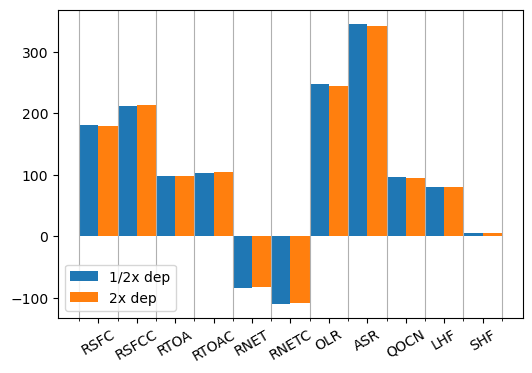

In [68]:
# 2D comparisons (like in comp_rcemip)
#### user input ####
plot_type="rad" #options: "rad" for radiation, "water" for hydrometeors
plot=True
#### end user input ####
var_list_rad = ["RSFC", "RSFCC","RTOA","RTOAC","RNET","RNETC","OLR","ASR","QOCN","LHF","SHF"]
var_list_water = ["PW","PR","LWP","IWP","WVP"]
fig, ax = plt.subplots(1,1,figsize=(6,4))
savename=plot_type+"_"
for i in range(len(runs)):
    ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h1.2000-01-01-00000.nc".format(runs[i],runs[i]))
    ds = ds.isel(time=slice(-nt, -1))
    var_dict = {}
    savename = savename + runs[i][-2:] + "-"
    if plot_type=="rad":
        # rsfc, the net radiative flux at the sfc (SW-LW)
        var_dict["RSFC"] = (ds["FSNS"]-ds["FLNS"]).mean()
        var_dict["RSFCC"] = (ds["FSNSC"]-ds["FLNSC"]).mean()
        # rtoa, the net radiative flux at toa (SW-LW)
        var_dict["RTOA"] = (ds["FSNTOA"]-ds["FLUT"]).mean()
        var_dict["RTOAC"] = (ds["FSNTOAC"]-ds["FLUTC"]).mean()
        # rnet = rtoa − rsfc, where negative values indicate net atmospheric radiative cooling
        var_dict["RNET"] = ((ds["FSNTOA"]-ds["FLUT"]) - (ds["FSNS"]-ds["FLNS"])).mean()
        var_dict["RNETC"] = ((ds["FSNTOAC"]-ds["FLUTC"]) - (ds["FSNSC"]-ds["FLNSC"])).mean()
        # olr
        var_dict["OLR"] = ds["FLUT"].mean()
        # asr, absorbed sw radiation (i.e., net SW flux at TOA (total incoming - total outgoing))
        var_dict["ASR"] = ds["FSNTOA"].mean()
        # energy input into ocean
        var_dict["QOCN"] = ((ds["FSNS"]-ds["FLNS"])-ds["LHFLX"]-ds["SHFLX"]).mean()
        # lhf, latent heat flux
        var_dict["LHF"] = ds["LHFLX"].mean()
        # shf, sensible heat flux
        var_dict["SHF"] = ds["SHFLX"].mean()
        units_dict = zip(var_list_rad,["W/m2"]*len(var_list_rad))
    else: #plot_type=="water"
        # pw, precipitable water
        var_dict["PW"] = ds["TMQ"].mean()
        # precip, precipitation rate
        var_dict["PR"] = ((ds.PRECL)*1000*3600*24).mean() #m/s --> mm/day ==> m/s * 1000 mm/m * 3600s/1hr * 24hr/day = mm/day
        # LWP, liquid water path
        var_dict["LWP"] = ds["TGCLDLWP"].mean()
        # IWP, ice water path
        var_dict["IWP"] = ds["TGCLDIWP"].mean()
        # clwvi_avg, water vapor path
        var_dict["WVP"] = ds["TGCLDCWP"].mean()
        units_dict = zip(var_list_water,["kg/m2","mm/day","kg/m2","kg/m2","kg/m2"])
    # plot
    if plot_type=="rad":
        var_list=var_list_rad
    else:
        var_list=var_list_water
        if i==0:
            axt = ax.twinx()
    for j in range(len(var_list)):
        ci = "C0" if i==0 else "C1"
        if j==0:
            ax.bar(j+(i/len(runs)),var_dict[var_list[j]], color=ci, width=0.5, label=run_names[i])
        else:
            if (plot_type=="water") & (j>1):
                axt.bar(j+(i/len(runs)),var_dict[var_list[j]], color=ci, width=0.5)
                axt.set_yscale("log")
                axt.axvline(1.75, color='k')
                axt.set_ylim([1e-2,3e-1])
            else:
                ax.bar(j+(i/len(runs)),var_dict[var_list[j]], color=ci, width=0.5)
ax.set_xticks(np.arange(0.25,len(var_list),1), var_list)
ax.set_xticks(np.arange(-0.25,len(var_list),1), minor=True)
ax.tick_params(axis='x', labelrotation=30)
ax.legend(loc=3)
ax.grid(axis='x', which='minor')
print("save as plots/compare_runs_{}.png".format(savename[:-1]))
plt.savefig("plots/compare_runs_{}.png".format(savename[:-1]))
plt.show()

saving to plots/compare_runs_QICLDFRAC_in-cld-IWC_1e-08_CK-CG-CF.png


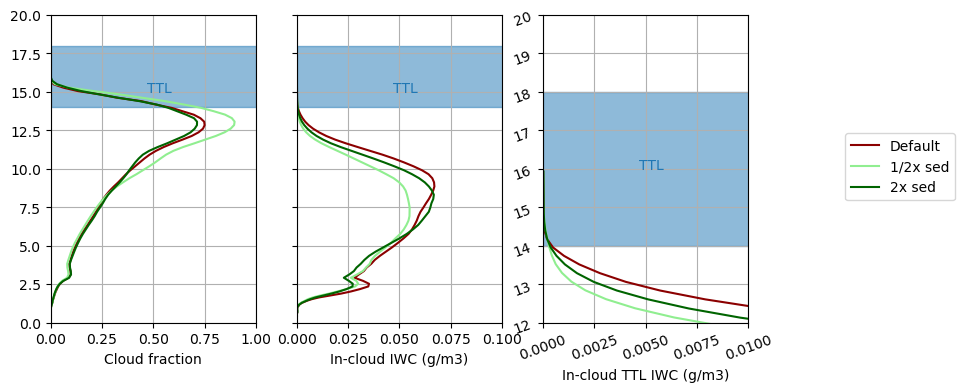

In [38]:
## plot in-cloud mean IWC and cloud fraction for given runs
## zoom into the TTL 
# runs = ["ck","ch"]

fig, ax = plt.subplots(1,3, figsize=(9,4))
xmaxs = [1,0.1,1e-2]
qsmall=1e-8 #kg/kg
savename="QICLDFRAC_in-cld-IWC_"+str(qsmall)+"_"
for i in range(len(runs)):
    ### get cloud fraction and in-cloud mean IWC
    
    file = run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i],runs[i])
    ds = xr.open_dataset(file).isel(time=slice(-nt,-1))
    z = ds.Z3.mean(dim=["time","ncol"])/1000
    if savename[:3]=="CLD":
        ### defined by qsmall IWC 
        ds = ds.IWC
        cld_frac = np.mean(np.where(ds>qsmall,1,0), axis=(0,2))
        incld_iwc = ds.where(ds>qsmall).mean(dim=["time","ncol"])
        del ds
    elif savename[:3]=="QIC":
        ### defined by qsmall QI 
        cld_frac = np.mean(np.where(ds.CLDICE>qsmall,1,0), axis=(0,2))
        incld_iwc = ds.IWC.where(ds.CLDICE>qsmall).mean(dim=["time","ncol"])
        del ds
    else:
        ### defined by model output of cloud fraction CLOUD
        cld_frac = ds.CLOUD.mean(dim=["time","ncol"])
        incld_iwc = ds.IWC.where(ds.CLOUD==1).mean(dim=["time","ncol"])
        del ds
    if i==color_hi or i==0 or i==color_hi1:
        c = colors[i]
        a = 1
        savename = savename + runs[i].upper()+"-"
    else:
        c = "gray"
        a = 0.3
        savename = savename + runs[i].lower()+"-"
    ### plot cld fraction, in-cld iwc, ttl in cld iwc
    ax[0].plot(cld_frac, z, color=c, alpha=a, label=run_names[i])
    ax[1].plot(incld_iwc*1000, z, color=c, alpha=a)
    ax[2].plot(incld_iwc*1000, z, color=c, alpha=a)
    xmaxs = np.max(np.array([xmaxs,[cld_frac.max(), incld_iwc.max(),incld_iwc[28:65].max()]]), axis=0)
    
ax[0].set_xlabel("Cloud fraction")
ax[1].set_xlabel("In-cloud IWC (g/m3)")
ax[2].set_xlabel("In-cloud TTL IWC (g/m3)")

for j in range(3):
    ax[j].grid(True)
    ax[j].fill_between([0, 1], 14, 18, color="C0", alpha=0.5)
    if j==2:
        ax[j].annotate("TTL", color="C0", xy=(0.47,0.5), xycoords="axes fraction")
        ax[j].set_ylim([12,20])
    else:
        ax[j].annotate("TTL", color="C0", xy=(0.47,0.75), xycoords="axes fraction")
        ax[j].set_ylim([0,20])
ax[0].set_xlim([0,xmaxs[0]])
ax[1].set_xlim([0,xmaxs[1]])
ax[2].set_xlim([0,xmaxs[2]])
ax[1].set_yticklabels([])
ax[2].tick_params(labelrotation=20)
fig.legend(loc=6, bbox_to_anchor=(1.0, 0.5))
print("saving to plots/compare_runs_{}.png".format(savename[:-1]))
plt.savefig("plots/compare_runs_{}.png".format(savename[:-1]), dpi=120, bbox_inches="tight",pad_inches=1)
plt.show()